In [1]:
import geopandas as gpd
from pyproj import Proj, transform
from shapely.geometry import Point
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from pyproj import Proj, transform
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
import dask.dataframe as dd
from rasterio.transform import from_origin
import numpy as np
import rasterio



In [2]:
local_crs = 27700
place = "glasgow"
lat = 55.86421405612109
lon = -4.251846930489373
country = "UK"
crs=4326
radius=15

In [ ]:
# Parameters
place = 'Birmingham'
lat = 52.47790683186595
lng = -1.8999014571831943
country = 'UK'
crs = 4326
local_crs = 27700


In [3]:
lonlat=(lon, lat)

In [4]:
buildings = gpd.read_parquet(f"./output/{place}/buildings_morphometric_var.pq")
tessellation = gpd.read_parquet(f"./output/{place}/tessellation_morphometric_var.pq")
# streets = gpd.read_parquet(f"output/{place}/--PST processed file--")
stroke = gpd.read_parquet(f"output/{place}/stroke_gdf.pq")

In [5]:
buildings_merged = buildings.merge(tessellation.drop(columns=['geometry']), on='uID', how='inner')
buildings_merged_centroids = buildings_merged
buildings_merged_centroids["geometry"] = buildings_merged_centroids['geometry'].centroid

In [6]:
# Your latitude and longitude tuple (latitude, longitude)

# Transform the coordinates
centre_point_4326 = Point(lon, lat)
x_centre, y_centre = transform(4326, local_crs, lat, lon)
centre_point_local_crs = Point(x_centre, y_centre)

C:\Users\reube\AppData\Local\Temp\ipykernel_15748\4192890295.py:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_centre, y_centre = transform(4326, local_crs, lat, lon)


## Linear Regression

In [7]:
buildings_merged_centroids['distance_to_centre'] = buildings_merged_centroids['geometry'].distance(centre_point_4326)
buildings_merged = buildings_merged_centroids.drop(columns=["uID", "geometry"])
buildings_merged = buildings_merged.dropna()

In [8]:
# Response variable
y = buildings_merged['distance_to_centre']

# Feature variables (excluding the response variable)
X = buildings_merged.drop(columns=['distance_to_centre'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Coefficients and Intercept
coefficients = model.coef_
intercept = model.intercept_

# Predictions
predictions = model.predict(X_scaled)

# Number of observations and number of features
n = len(y)
p = X.shape[1]

# Residual Sum of Squares and Total Sum of Squares
rss = np.sum((y - predictions) ** 2)
tss = np.sum((y - np.mean(y)) ** 2)

# R-squared and Adjusted R-squared
r_squared = 1 - (rss / tss)
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

# Standard Error of the coefficients
mse = rss / (n - p - 1)
se = np.sqrt(np.diagonal(mse * np.linalg.inv(np.dot(X_scaled.T, X_scaled))))

# t-statistics and p-values for coefficients
t_stats = coefficients / se
p_values = [2 * (1 - stats.t.cdf(np.abs(t), n - p - 1)) for t in t_stats]

# F-statistic
f_statistic = (r_squared / p) / ((1 - r_squared) / (n - p - 1))

def get_significance_asterisks(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Standard Error': se,
    't value': t_stats,
    'p value': p_values,
    'Significance': [get_significance_asterisks(p) for p in p_values]
}, index=X.columns)
summary_df.loc['Intercept'] = [intercept, np.nan, np.nan, np.nan, '']

# Print summary statistics
print(f"Number of Observations: {n}")
print(f"R-squared: {r_squared}")
print(f"Adjusted R-squared: {adjusted_r_squared}")
print(f"F-statistic: {f_statistic}\n")

Number of Observations: 257087
R-squared: 0.04648263994370949
Adjusted R-squared: 0.04638990734716075
F-statistic: 501.25459303077645



In [9]:
summary_df

,Coefficient,Standard Error,t value,p value,Significance
buildings_neighbours_200,78.395356,21.413574,3.661012,2.512711e-04,***
building_area,-14.188521,14.109344,-1.005612,3.146033e-01,
building_circular_compactness,-28.792860,35.336397,-0.814822,4.151752e-01,
building_elongation,-55.272012,31.302817,-1.765720,7.744401e-02,
building_squareness,8.324084,14.284155,0.582749,5.600625e-01,
building_eri,32.126995,22.822997,1.407659,1.592333e-01,
building_orientation,20.337355,18.690079,1.088136,2.765359e-01,
building_neighbour_dist,-18.882685,21.622108,-0.873305,3.824979e-01,
building_neighbourhood_interbuilding_distance,84.374578,46.997882,1.795285,7.260953e-02,
building_circular_compactness_weight,697.955106,53.804036,12.972170,0.000000e+00,***


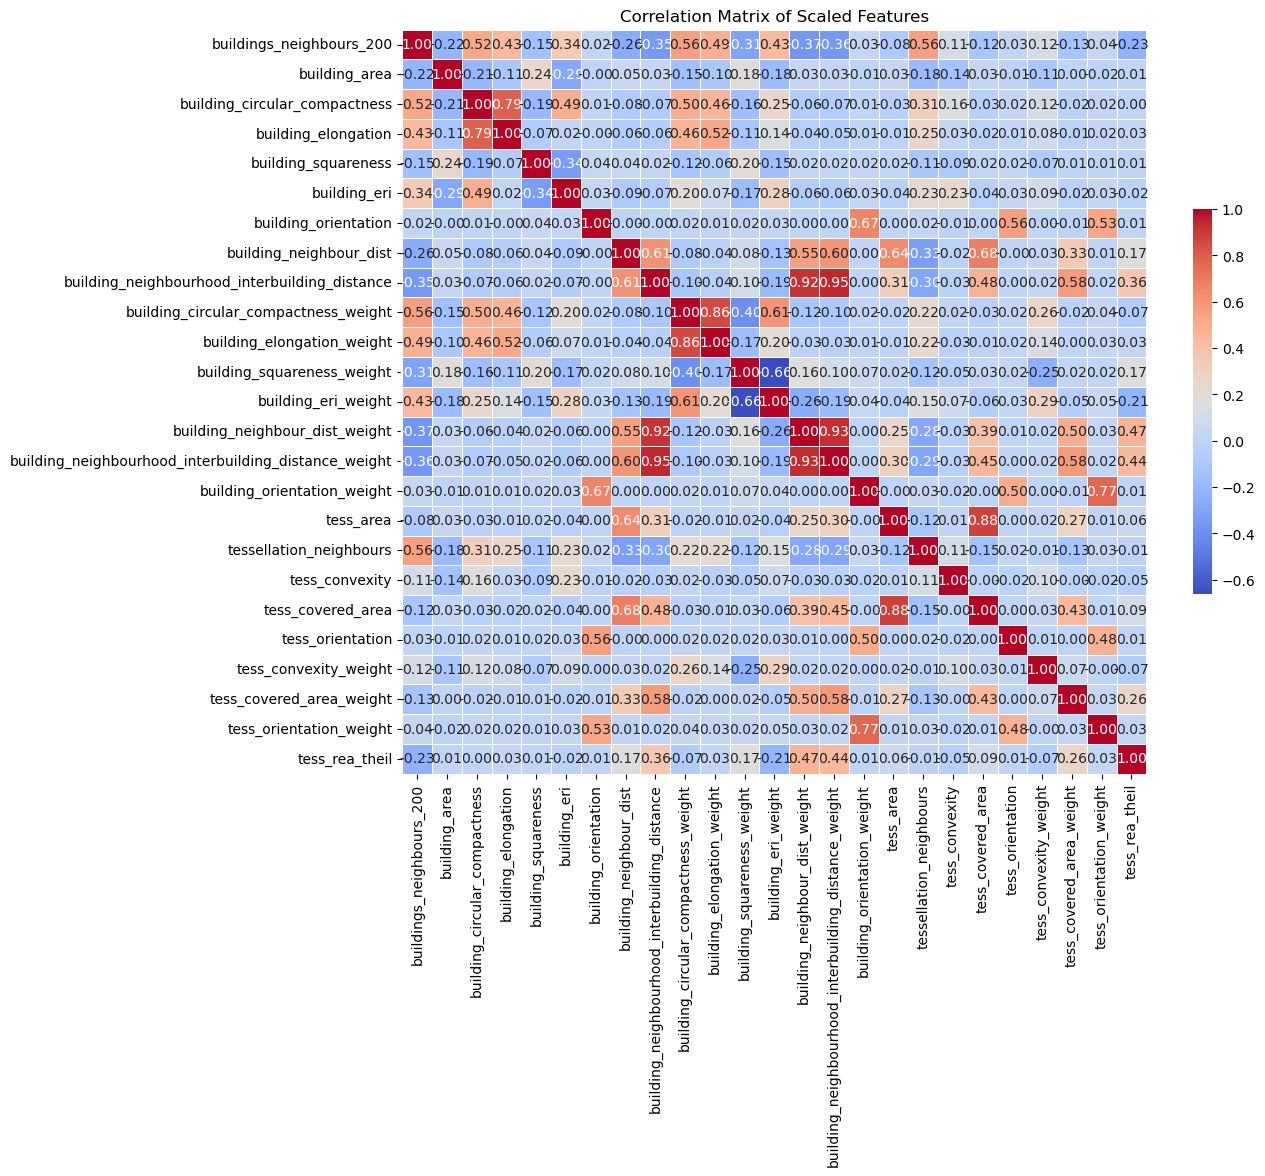

In [10]:
# Convert the numpy array back to a pandas DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Calculate the correlation matrix
corr_matrix = X_scaled_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Adding title
plt.title('Correlation Matrix of Scaled Features')

# Show the plot
plt.show()

In [11]:
residuals = y - predictions

In [12]:
# # Creating a residual plot with Seaborn
# plt.figure(figsize=(10, 6))
# sns.residplot(x=predictions, y=residuals, lowess=True, scatter_kws={'alpha': 0.05, 's': 10}, line_kws={'color': 'red'})
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.title('Seaborn Residual Plot')
# plt.show()

In [13]:
# plt.figure(figsize=(8, 6))
# stats.probplot(residuals, dist="norm", plot=plt)
# plt.title('Q-Q Plot of Residuals')
# plt.xlabel('Theoretical Quantiles')
# plt.ylabel('Ordered Values')
# plt.show()

In [14]:
height_cells = gpd.read_parquet(f"output/{place}/height_cells.pq").to_crs(local_crs)

In [15]:
height_cells

,raster_val,row,col,geometry
0,255,0,0,"POLYGON ((244406.404 681541.480, 244468.511 68..."
1,255,0,1,"POLYGON ((244468.511 681539.234, 244530.618 68..."
2,255,0,2,"POLYGON ((244530.618 681536.990, 244592.725 68..."
3,255,0,3,"POLYGON ((244592.725 681534.747, 244654.832 68..."
4,255,0,4,"POLYGON ((244654.832 681532.504, 244716.939 68..."
...,...,...,...,...
135235,255,275,485,"POLYGON ((273642.970 650074.590, 273705.522 65..."
135236,255,275,486,"POLYGON ((273705.522 650072.773, 273768.074 65..."
135237,255,275,487,"POLYGON ((273768.074 650070.956, 273830.626 65..."
135238,255,275,488,"POLYGON ((273830.626 650069.140, 273893.178 65..."


In [16]:
# Create a 50 km buffer around the point
buffer_circle = gpd.GeoDataFrame({'geometry': [Point(lon, lat)]}, crs=4326).to_crs(local_crs).buffer(radius * 1000)

In [17]:
# Get bounds
minx, miny, maxx, maxy = height_cells.total_bounds
min_dist = min([abs(minx-lonlat[1]), abs(miny-lonlat[0]), abs(maxx-lonlat[1]), abs(maxy-lonlat[0])])

# Create a GeoDataFrame with the specified point
gdf = gpd.GeoDataFrame(geometry=[Point(lonlat[0], lonlat[1])], crs=crs)

# The UTM zone number can be calculated from the longitude
utm_zone = int((lonlat[0] + 180) / 6) + 1
# Determine the hemisphere and assign the appropriate UTM CRS
if lonlat[1] >= 0:  # Northern Hemisphere
    local_utm_crs = f'EPSG:326{utm_zone:02d}'
else:  # Southern Hemisphere
    local_utm_crs = f'EPSG:327{utm_zone:02d}'

# Reproject to a local UTM CRS
gdf_utm = gdf.to_crs(local_utm_crs)

# Create a 50 km buffer around the point
buffer_circle = gdf_utm.buffer((radius) * 1000).to_crs(local_crs)  # Convert km to meters


In [18]:
buffer_circle.explore()

In [19]:
# # Create a plot
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot the first GeoDataFrame
# cells_in_circle.plot(ax=ax, color='blue', edgecolor='k', alpha=0.2)  # Adjust color and edgecolor as needed

# # Plot the second GeoDataFrame on the same axes
# buffer_circle.plot(ax=ax, color='red', alpha=0.2)  # Adjust color and alpha for transparency as needed

# tessellation.plot(ax=ax, color="green", alpha=0.4)

# # Optionally set axis limits or other plot properties
# # ax.set_xlim([xmin, xmax])
# # ax.set_ylim([ymin, ymax])

# ctx.add_basemap(ax, crs=local_crs,source=ctx.providers.CartoDB.Positron)

# plt.show()

In [20]:
cells_in_circle = height_cells[height_cells["geometry"].within(buffer_circle.geometry[0])]


In [21]:
# cells_in_circle.plot()

In [22]:
cells_in_circle 

,raster_val,row,col,geometry
1700,0,3,230,"POLYGON ((258680.583 680716.235, 258742.698 68..."
1701,0,3,231,"POLYGON ((258742.698 680714.195, 258804.814 68..."
1702,0,3,232,"POLYGON ((258804.814 680712.156, 258866.930 68..."
1703,0,3,233,"POLYGON ((258866.930 680710.118, 258929.045 68..."
1704,0,3,234,"POLYGON ((258929.045 680708.081, 258991.161 68..."
...,...,...,...,...
133064,2,271,274,"POLYGON ((260458.713 650921.674, 260521.257 65..."
133527,0,272,247,"POLYGON ((258766.437 650865.350, 258828.982 65..."
133528,0,272,248,"POLYGON ((258828.982 650863.319, 258891.527 65..."
133529,0,272,249,"POLYGON ((258891.527 650861.289, 258954.072 65..."


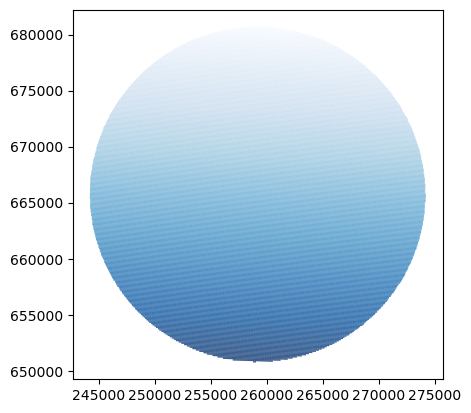

In [23]:
# Assuming cells_in_circle is a GeoDataFrame
fig, ax = plt.subplots()
cells_in_circle.plot(column='row', ax=ax, cmap='Blues')
plt.show()

In [24]:
buildings_joint = buildings.sjoin(cells_in_circle, how='inner')

In [25]:
buildings_joint

,uID,geometry,buildings_neighbours_200,building_area,building_circular_compactness,building_elongation,building_squareness,building_eri,building_orientation,building_neighbour_dist,...,building_elongation_weight,building_squareness_weight,building_eri_weight,building_neighbour_dist_weight,building_neighbourhood_interbuilding_distance_weight,building_orientation_weight,index_right,raster_val,row,col
0,0,"POLYGON ((253894.911 667992.009, 253874.743 66...",0.572746,393.721492,0.611691,0.977599,0.023740,0.811813,3.700646,11.330833,...,0.786643,0.039673,0.758527,60.392427,41.977459,10.357672,58469,7,119,159
8820,8820,"POLYGON ((253844.484 667989.838, 253844.622 66...",0.577306,421.556464,0.580966,0.847610,0.002635,0.820254,1.435658,16.154748,...,0.751123,6.832751,0.731154,68.431139,43.330030,11.929334,58469,7,119,159
41472,41472,"POLYGON ((253870.028 667937.639, 253870.065 66...",2.075097,49.133134,0.602415,0.715285,0.006788,1.000001,0.367372,66.859474,...,0.485869,10.656290,0.840230,62.008052,47.364771,18.984083,58469,7,119,159
65707,65707,"POLYGON ((253845.773 667944.129, 253840.136 66...",0.983983,219.069831,0.660199,0.967117,0.006690,0.924824,0.393206,32.301081,...,0.505062,11.442692,0.848887,63.017564,48.173142,18.799870,58469,7,119,159
70973,70973,"POLYGON ((253870.996 667945.712, 253850.035 66...",0.815045,224.135798,0.379538,0.555722,0.010186,0.821445,9.507697,4.551870,...,0.513785,14.598003,0.842969,76.928060,46.967150,16.945453,58469,7,119,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256400,256400,"POLYGON ((264372.714 653234.378, 264427.116 65...",0.064490,2753.686882,0.302513,0.930912,0.122810,0.423292,43.770090,40.123598,...,0.696217,6.148398,0.787824,47.194174,46.073066,35.321815,121856,6,248,336
256410,256410,"POLYGON ((260958.330 654618.664, 260946.438 65...",0.115694,1118.338882,0.559094,0.594790,0.053638,1.000070,15.921896,64.108808,...,0.601687,10.527027,0.846961,66.799789,67.148260,21.452310,116410,5,237,280
256550,256550,"POLYGON ((265325.368 652515.758, 265314.684 65...",0.489809,59.539895,0.513067,0.506488,0.034472,1.000050,9.743888,81.206519,...,0.616834,5.664146,0.777030,180.423518,177.601444,17.593043,125300,5,255,350
256766,256766,"POLYGON ((263643.071 652253.602, 263631.206 65...",0.817606,167.759456,0.505564,0.494788,0.119453,1.000173,40.139844,26.152688,...,0.446565,0.044706,0.962583,43.729950,47.293133,14.565829,126744,6,258,324


In [26]:
joint_gdf = tessellation.join(buildings_joint, on="uID", how="inner", lsuffix="_tess", rsuffix="_build").drop(["uID_tess"], axis=1)

In [27]:
tessellation_not_in_buildings = tessellation[~tessellation['uID'].isin(buildings_joint['uID'])]

<Axes: >

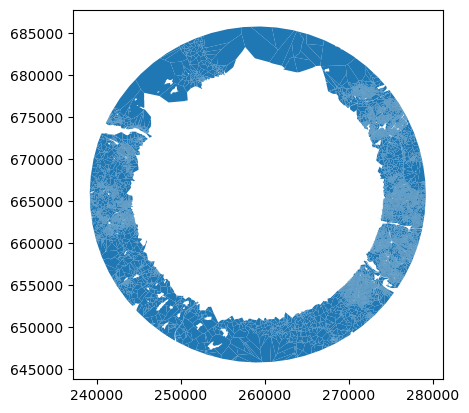

In [28]:
tessellation_not_in_buildings.plot()

In [29]:
joint_gdf.drop(["geometry_tess", "geometry_build", "uID"], axis=1).to_parquet(f"output/{place}/p4-buildings-output.pq")

In [30]:
# Assuming 'gdf' is your GeoDataFrame
# Convert GeoDataFrame to Dask DataFrame
dask_df = dd.from_pandas(joint_gdf.drop(["geometry_tess", "geometry_build", "uID", "uID_build", "index_right", "raster_val"], axis=1), npartitions=10)  # You can adjust the number of partitions

# Group by 'row' and 'col'
grouped = dask_df.groupby(["row", "col"])

stats_df = grouped.aggregate(['median', "std"], shuffle='tasks').compute()

In [31]:
out = {}

for column in joint_gdf.drop(["geometry_tess", "geometry_build", "uID", "uID_build", "index_right", "raster_val", "row", "col"], axis=1).columns:
    print(column)
    q25 = grouped[column].apply(lambda x: x.quantile(0.25), meta=('x', 'f8')).compute()
    q25.name = f"q25"
    q75 = grouped[column].apply(lambda x: x.quantile(0.75), meta=('x', 'f8')).compute()
    q75.name = f"q75"
    kurtosis = grouped[column].apply(lambda x: x.kurtosis(), meta=('x', 'f8')).compute()
    kurtosis.name = f"kurtosis"
    skew =  grouped[column].apply(lambda x: x.skew(), meta=('x', 'f8')).compute()
    skew.name = f"skew"
    
    out[column] = [stats_df[column], q25, q75, kurtosis, skew]


tess_area
tessellation_neighbours
tess_convexity
tess_covered_area
tess_orientation
tess_convexity_weight
tess_covered_area_weight
tess_orientation_weight
tess_rea_theil
buildings_neighbours_200
building_area
building_circular_compactness
building_elongation
building_squareness
building_eri
building_orientation
building_neighbour_dist
building_neighbourhood_interbuilding_distance
building_circular_compactness_weight
building_elongation_weight
building_squareness_weight
building_eri_weight
building_neighbour_dist_weight
building_neighbourhood_interbuilding_distance_weight
building_orientation_weight


In [33]:
test = pd.DataFrame()

In [34]:
for key in out:
    # Concatenate the Series
    concatenated = pd.concat(out[key], axis=1)

    # Create a MultiIndex using the key and the column names of the concatenated DataFrame
    multi_index = pd.MultiIndex.from_tuples([(key, col) for col in concatenated.columns])

    # Set the MultiIndex to the concatenated DataFrame
    concatenated.columns = multi_index

    # Combine the concatenated DataFrame into stats_df
    test = pd.concat([test, concatenated], axis=1)

In [35]:
# Assume df is your DataFrame

# Transpose the DataFrame
df_transposed = test.T

# Find duplicated rows (originally columns)
duplicates = df_transposed.duplicated()

# List out the names of duplicate columns
duplicate_columns = df_transposed.index[duplicates].tolist()

# Print or process the duplicate column names
print("Duplicate columns:", duplicate_columns)

Duplicate columns: []


In [36]:
# Calculate the count of entries in each cell
cell_counts = dask_df.groupby(['row', 'col']).size().compute()
cell_counts_df = cell_counts.reset_index(name='entry_count')

In [37]:
height_cells.set_index(['row', 'col'], inplace=True)

In [38]:
out_df = gpd.GeoDataFrame(pd.concat([test, height_cells], axis=1).reset_index(), geometry="geometry")
out_df = out_df.merge(cell_counts_df, on=['row', 'col'], how='left')

In [39]:
out_df.columns = ['_'.join(map(str, col)) if type(col) is tuple else col for col in out_df.columns]

In [40]:
df = out_df.loc[:,~out_df.columns.duplicated()].copy()

In [41]:
df.rename(columns={'raster_val': 'building_height'}, inplace=True)

In [42]:
df.to_parquet(f"output/{place}/p4-grid-output.pq")

In [43]:
gdf = df[df['building_height'] != 255]

<Axes: >

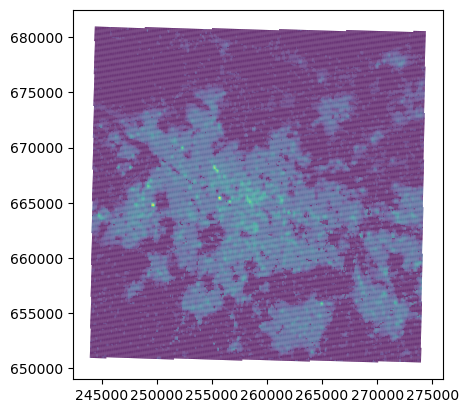

In [44]:
gdf.plot(column='building_height')

In [45]:
with rasterio.open(f'output/{place}.tif') as src:
    # Get the transform object
    transform = src.transform

    # Extract west, north, and resolution (xres, yres)
    west = transform.c
    north = transform.f
    xres = transform.a
    yres = -transform.e  # yres is negative as raster origin is top-left


In [ ]:

# Open the source raster to get the transform
with rasterio.open(f'output/{place}.tif') as src:
    transform = src.transform

    west = transform.c
    north = transform.f
    xres = transform.a
    yres = -transform.e  # yres is negative as raster origin is top-left

# Calculate raster dimensions
n_rows = gdf['row'].max() - gdf['row'].min() + 1
n_cols = gdf['col'].max() - gdf['col'].min() + 1

# List of columns to be used as bands
band_columns = [col for col in gdf.columns if col not in ['row', 'col', 'geometry']]

# Initialize raster dataset
with rasterio.open(f"output/{place}/grid_with_summary_stats.tif", 'w', 
    driver='GTiff', 
    height=n_rows, 
    width=n_cols, 
    count=len(band_columns), 
    dtype=str(gdf[band_columns[0]].dtype), 
    crs=gdf.crs, 
    transform=transform
) as dst:
    for i, column in enumerate(band_columns, start=1):
        # Create an empty array filled with NaNs (or use a different no-data value)
        if column == 'building_height':
            # For 'building_height', initialize with zeros
            band_data = np.zeros((n_rows, n_cols))
        else:
            # For other columns, initialize with NaNs
            band_data = np.full((n_rows, n_cols), np.nan)

        # Update the array with data from the GeoDataFrame
        for _, row in gdf.iterrows():
            row_idx, col_idx = row['row'] - gdf['row'].min(), row['col'] - gdf['col'].min()
            band_data[row_idx, col_idx] = row[column]

        dst.write(band_data, i)

In [46]:
gdf['distance_to_centre'] = gdf['geometry'].distance(centre_point_local_crs)

In [ ]:
new_gdf = gdf.drop(columns=["geometry", "row", "col"]).dropna()

In [ ]:
# Response variable
y = new_gdf['distance_to_centre']

# Feature variables (excluding the response variable)
X = new_gdf.drop(columns=['distance_to_centre'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Coefficients and Intercept
coefficients = model.coef_
intercept = model.intercept_

# Predictions
predictions = model.predict(X_scaled)

# Number of observations and number of features
n = len(y)
p = X.shape[1]

# Residual Sum of Squares and Total Sum of Squares
rss = np.sum((y - predictions) ** 2)
tss = np.sum((y - np.mean(y)) ** 2)

# R-squared and Adjusted R-squared
r_squared = 1 - (rss / tss)
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

# Standard Error of the coefficients
mse = rss / (n - p - 1)
se = np.sqrt(np.diagonal(mse * np.linalg.inv(np.dot(X_scaled.T, X_scaled))))

# t-statistics and p-values for coefficients
t_stats = coefficients / se
p_values = [2 * (1 - stats.t.cdf(np.abs(t), n - p - 1)) for t in t_stats]

# F-statistic
f_statistic = (r_squared / p) / ((1 - r_squared) / (n - p - 1))

def get_significance_asterisks(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Standard Error': se,
    't value': t_stats,
    'p value': p_values,
    'Significance': [get_significance_asterisks(p) for p in p_values]
}, index=X.columns)
summary_df.loc['Intercept'] = [intercept, np.nan, np.nan, np.nan, '']

# Print summary statistics
print(f"Number of Observations: {n}")
print(f"R-squared: {r_squared}")
print(f"Adjusted R-squared: {adjusted_r_squared}")
print(f"F-statistic: {f_statistic}\n")

Number of Observations: 29977
R-squared: 0.3310436443217929
Adjusted R-squared: 0.32758917182583547
F-statistic: 95.83044725618444



In [ ]:
summary_df.to_string()

'                                                               Coefficient  Standard Error    t value       p value Significance\nrow                                                             833.677720       18.266486  45.639743  0.000000e+00          ***\ncol                                                              93.258814       17.299619   5.390802  7.067611e-08          ***\ntess_area_median                                                 95.493326       56.480582   1.690728  9.089913e-02             \ntess_area_std                                                    89.329228       76.528784   1.167263  2.431135e-01             \ntess_area_q25                                                  -124.939838       35.218961  -3.547516  3.894784e-04          ***\ntess_area_q75                                                   -63.113488       81.726108  -0.772256  4.399689e-01             \ntess_area_kurtosis                                              -43.462494       31.63994

In [54]:
# Assuming 'summary_df' is your DataFrame
# Set the display options
pd.set_option('display.max_rows', None)  # Replace None with a specific number if the DataFrame is very large
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # Adjust the width for better readability if necessary
pd.set_option('display.max_colwidth', None)  # Adjust column width to show full content of each cell

In [ ]:
summary_df

,Coefficient,Standard Error,t value,p value,Significance
row,833.677720,18.266486,45.639743,0.000000e+00,***
col,93.258814,17.299619,5.390802,7.067611e-08,***
tess_area_median,95.493326,56.480582,1.690728,9.089913e-02,
tess_area_std,89.329228,76.528784,1.167263,2.431135e-01,
tess_area_q25,-124.939838,35.218961,-3.547516,3.894784e-04,***
tess_area_q75,-63.113488,81.726108,-0.772256,4.399689e-01,
tess_area_kurtosis,-43.462494,31.639943,-1.373659,1.695579e-01,
tess_area_skew,78.860768,32.123428,2.454930,1.409687e-02,*
tessellation_neighbours_median,198.428865,71.670619,2.768622,5.632862e-03,**
tessellation_neighbours_std,-64.028066,42.297345,-1.513761,1.300971e-01,
